# **Notebook: NumPy Implementation of a Fully-Connected Neural Network using ADAM update

This notebook runs a fully connected neural network. It is built solely with NumPy function, that means it does not use any advanced libraries liek PyTorch or TensorFlow. 
The Neural Network is trained on the 2 dimensional MNIST data set. 


In [1]:
import numpy as np
import imageio
import glob
from matplotlib import pyplot as plt
import time
import sys

In [2]:
# Loads data
def load_mnist(): 
    NUM_LABELS = 10        
    test_images = []
    test_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Test/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            test_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            test_labels.append(letter)  
            
    train_images = []
    train_labels = []    
    
    for label in range(NUM_LABELS):
        for image_path in glob.glob("MNIST/Train/" + str(label) + "/*.png"):
            image = imageio.imread(image_path)
            train_images.append(image)
            letter = [0 for _ in range(0,NUM_LABELS)]    
            letter[label] = 1
            train_labels.append(letter)                  
            
    X_train= np.array(train_images).reshape(-1,784)/255.0
    Y_train= np.array(train_labels)
    X_test= np.array(test_images).reshape(-1,784)/255.0
    Y_test= np.array(test_labels)
    
    return X_train, Y_train, X_test, Y_test

In [3]:
def initialize(model):
    np.random.seed(42)

    # Number of hidden layers
    K = len(model) 
    # Number of neurons per layer
    D = model
    # Input layer dimension
    D_i = 784
    # Output layer dimension
    D_o = 10

    # Make empty lists
    all_weights = [None] * (K+1)
    all_biases = [None] * (K+1)

# Create input and output layer
    if K==0:
        all_weights[0] = np.random.normal(0, np.sqrt(2/(D_i)), size=(D_i, D_o))
        all_biases[0]  = np.zeros((1, D_o))
    else:
        all_weights[0] = np.random.normal(0, np.sqrt(2/(D_i )), size=(D_i, D[0]))
        all_weights[-1] = np.random.normal(0, np.sqrt(2/(D[-1])), size=(D[-1], D_o))
        all_biases[0] = np.zeros((1, D[0]))
    
    all_biases[-1]= np.zeros((1, D_o))

# Create intermediate layers
    for layer in range(1,K):
        all_weights[layer] = np.random.normal(0, np.sqrt(2/(D[layer-1])), size=(D[layer-1],D[layer]))
        all_biases[layer] = np.zeros((1, D[layer]))

# Initialize ADAM parameters    
    m_w = [np.zeros_like(w) for w in all_weights]
    m_b = [np.zeros_like(b) for b in all_biases]

    v_w = [np.zeros_like(w) for w in all_weights]
    v_b = [np.zeros_like(b) for b in all_biases]

    return all_weights, all_biases, m_w, m_b, v_w, v_b

In [4]:
# ReLU activation function
def ReLU_activation(preactivation):
    activation = preactivation.clip(0.0)
    return activation
    
    

# Indicator function - Derivative of ReLU
def indicator_function(x):
    x_in = np.array(x)
    x_in[x_in>0] = 1
    x_in[x_in<=0] = 0
    return x_in


In [5]:
# Forward propagation function
def forward_pass(net_input, all_weights, all_biases):

    K = len(all_weights) -1

    all_f = [None] * (K+1)
    all_h = [None] * (K+1)

    all_h[0] = net_input

    for layer in range(K):
        all_f[layer] =  np.matmul(all_h[layer], all_weights[layer]) + all_biases[layer]
        all_h[layer+1] = ReLU_activation(all_f[layer])

    all_f[K] = np.matmul(all_h[K], all_weights[K]) + all_biases[K]   

    net_output = all_f[K]    

    return net_output, all_f, all_h 

Now let's define a cost function. We'll just use the least squares loss function for this. We'll also write a function to compute d_cost_d_output.


In [6]:
# Softmax function
def softmax(net_output):

    row_sum = np.sum(np.exp(net_output), axis = 1, keepdims=True)
    P_K = np.exp(net_output) / row_sum

    return P_K

Now let's compute the derivatives of the network.  We already computed the forward pass.  Let's compute the backward pass.

In [7]:
# Function to compute cost using cross entropy loss
def compute_cost(net_output, y_batch): 

    # cross entropy loss
    term1 = np.log(np.sum(np.exp(net_output), axis=1, keepdims=True)) 
    term2 = np.sum(y_batch*net_output, axis=1, keepdims=True)
    cross_entropy = term1 - term2

    # Sum over points
    I = y_batch.shape[0]
    cost = (1/I) * np.sum(cross_entropy)  
    return cost


In [8]:
# Derivative of cost with respect to the output
def d_cost_d_output(net_output, y):
    I = y.shape[0]
    P_K = softmax(net_output)
    result = (P_K - y)/I

    return result

In [9]:
# Backward propagation function
def backward_pass(all_weights, all_biases, all_f, all_h, y, K):
    all_dl_dweights = [None] * (K+1)
    all_dl_dbiases = [None] * (K+1)
    all_dl_df = [None] * (K+1)
    all_dl_dh = [None] * (K+1)

    all_dl_df[K] = np.array(d_cost_d_output(all_f[K],y))
    
    layer_range = range(K, -1, -1)  

    for layer in layer_range:
        all_dl_dbiases[layer] = np.sum(all_dl_df[layer], axis=0, keepdims=True)

        all_dl_dweights[layer] = np.matmul(all_h[layer].T, all_dl_df[layer])

        all_dl_dh[layer] = np.matmul(all_dl_df[layer], all_weights[layer].T)

        if layer > 0:
            all_dl_df[layer-1] = all_dl_dh[layer] * indicator_function(all_f[layer-1])

    return all_dl_dweights, all_dl_dbiases 

In [10]:
# Function to update parameters using ADAM update
def update_parameters(all_weights, all_biases, all_dl_dweights, all_dl_dbiases, alpha, beta, gamma, m_w, m_b, v_w, v_b, t):
    eps = 1e-8
    m_w_moderate = [np.zeros_like(w) for w in all_weights]
    m_b_moderate = [np.zeros_like(b) for b in all_biases]

    v_w_moderate = [np.zeros_like(w) for w in all_weights]
    v_b_moderate = [np.zeros_like(b) for b in all_biases]

    for layer in range(len(all_weights)):
        # compute new m_w, m_b
        m_w[layer] = beta * m_w[layer] + (1-beta) * all_dl_dweights[layer]
        m_b[layer] = beta * m_b[layer] + (1-beta) * all_dl_dbiases[layer]
        # compute new v_w, v_b
        v_w[layer] = gamma * v_w[layer] + (1-gamma) * (all_dl_dweights[layer]**2)
        v_b[layer] = gamma * v_b[layer] + (1-gamma) * (all_dl_dbiases[layer]**2)

        # Moderate
        m_w_moderate[layer] = m_w[layer]/(1-beta**(t+1))
        m_b_moderate[layer] = m_b[layer]/(1-beta**(t+1))
        v_w_moderate[layer] = v_w[layer]/(1-gamma**(t+1))
        v_b_moderate[layer] = v_b[layer]/(1-gamma**(t+1))

        all_weights[layer] = all_weights[layer] - alpha * (m_w_moderate[layer]/(np.sqrt(v_w_moderate[layer])+eps))
        all_biases[layer] = all_biases[layer] - alpha * (m_b_moderate[layer]/(np.sqrt(v_b_moderate[layer])+eps))

    t += 1

    return all_weights, all_biases, m_w, m_b, v_w, v_b, t

In [11]:
# Prediction function
def predict(net_input, y, all_weights, all_biases):
    
    K = len(all_weights) -1
    all_f = [None] * (K+1)
    all_h = [None] * (K+1)
    all_h[0] = net_input

    for layer in range(K):
 
        all_f[layer] =  np.matmul(all_h[layer], all_weights[layer]) + all_biases[layer]
        all_h[layer+1] = ReLU_activation(all_f[layer])

    all_f[K] = np.matmul(all_h[K], all_weights[K]) + all_biases[K]   
    net_output = all_f[K]

    prediction = np.argmax(softmax(net_output), axis=1)
    true_classes = np.argmax(y, axis=1)

    correct = 0
    for i in range(len(prediction)):
        if prediction[i] == true_classes[i]:
            correct += 1
    
    accuracy_score = correct/len(prediction)

    return compute_cost(net_output, y), accuracy_score

In [12]:
# Scramble the data and generate mini-batches
def random_mini_batches(X_train, Y_train, batch_size):
    # Get the indices to scramble them randomly
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    # use the same scramble to make sure X and Y align
    X_shuffled = X_train[indices, :]
    Y_shuffled = Y_train[indices, :]

    n = X_train.shape[0]//batch_size

    # split the sets into mini-batches 
    X_mini = np.array_split(X_shuffled, n, axis=0)
    Y_mini = np.array_split(Y_shuffled, n, axis=0)

    return X_mini, Y_mini

In [13]:
# Function to train model given a certain architecture
def train_model(x_train, y_train, model, num_epochs, learning_rate, batch_size, x_test, y_test, beta, gamma):

    # initialize weights and biases according to model
    all_weights, all_biases, m_w, m_b, v_w, v_b = initialize(model)
    
    # Time variable for ADAM update
    t = 0
    
    # Lists for tracking performance
    cost_list_test = []
    accuracy_list_test = []
    cost_list_training = []
    accuracy_list_training = []

    K = len(all_weights) -1

    start = time.time()
    for epoch in range(1, num_epochs+1):
        # get a randomized set of mini batches
        X_miniset, Y_miniset = random_mini_batches(x_train, y_train, batch_size)

        for b in range(len(X_miniset)):
            # 1: Forward pass
            net_output, all_f, all_h = forward_pass(X_miniset[b], all_weights, all_biases)

            # 2: Backward pass
            all_dl_dweights, all_dl_dbiases = backward_pass(all_weights, all_biases, all_f, all_h, Y_miniset[b], K)


            # 3: Update parameters
            all_weights, all_biases, m_w, m_b, v_w, v_b, t = update_parameters(all_weights, all_biases, all_dl_dweights, all_dl_dbiases, learning_rate, beta, gamma, m_w, m_b, v_w, v_b, t)

            if b%100 == 0:
                cost_training, accuracy_score_training = predict(X_miniset[b], Y_miniset[b], all_weights, all_biases)
                cost_list_training.append(cost_training)
                accuracy_list_training.append(accuracy_score_training)
    
                cost_test, accuracy_score_test = predict(x_test, y_test, all_weights, all_biases)
                cost_list_test.append(cost_test)
                accuracy_list_test.append(accuracy_score_test)

    elapsed = time.time() - start

    return cost_list_test, accuracy_list_test, cost_list_training, accuracy_list_training, elapsed

In [14]:
# Function to create plots
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, num_epochs, elapsed):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=0.98, fontsize=lg)    
    elapsed_min, elapsed_sec = divmod(elapsed, 60)
    sub = f'|  Batch size:{batch_size}  |  Learning rate:{learning_rate} | Number of Epochs:{num_epochs} | Training time: {elapsed_min:.0f} min {elapsed_sec:.1f} sec |'
    fig.text(0.5, 0.88, sub, ha='center', fontsize=md)
    x = np.array(range(1, len(train_costs)+1))*num_epochs/len(train_costs)
    x_test  = np.arange(1, len(test_costs) + 1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)  

    plt.tight_layout()
    plt.show()

In [15]:
# Load data into training and test sets
X_train, Y_train, X_test, Y_test = load_mnist()

/var/folders/9t/x7_mj7tj2q57m0b3fbchh3440000gn/T/ipykernel_89356/1461585082.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)
/var/folders/9t/x7_mj7tj2q57m0b3fbchh3440000gn/T/ipykernel_89356/1461585082.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


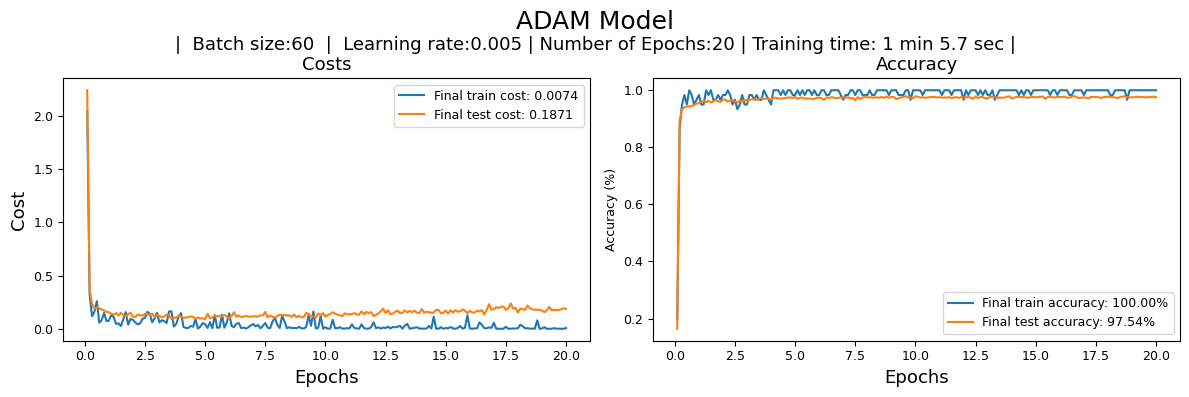

In [16]:
# Define hyperparameters, model architecture and train the model. 
model = [128, 64, 16]
batch_size = 60
epochs = 20
learning_rate = 0.005
beta = 0.9
gamma = 0.99

cost_list_test, accuracy_list_test, cost_list_training, accuracy_list_training, elapsed = train_model(X_train, Y_train, model, epochs, learning_rate, batch_size, X_test, Y_test, beta, gamma)

training_curve_plot("ADAM Model", cost_list_training, cost_list_test, accuracy_list_training, accuracy_list_test, batch_size, learning_rate, epochs, elapsed)